In [1]:
# standard python modules
import numpy as np;import time;import copy

# plotting utilities
import matplotlib.pyplot as plt;import matplotlib as mpl;import matplotlib.cm as cm;import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno

import scipy.interpolate as interpolate;import subprocess;from astropy.io import fits

# exptool imports
#from exptool.basis import eof;from exptool.basis import spheresl;from exptool.basis import *

#from ssl import *;from exptool.io import psp_io

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

#from exptool.utils import *

stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True


# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # following the astropy conversion
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub


#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(KGiant.x),np.array(KGiant.y),np.array(KGiant.z),\
#                               np.array(KGiant.vx),np.array(KGiant.vy),np.array(KGiant.vz))






# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)




#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)





In [213]:
# generate a sphere of stars

def gen_sphere_surface(npoints,cartesian=True):
    """generate evenly spaced points on the surface of a sphere
    
    inputs
    -------------
    npoints    : integer
        the maximum number of points to generate on the surface of the sphere
    cartesian  : boolean, default True
        if true, return (x,y,z). If false, return (phi,theta)
    
    note that npoints is the maximum, because we are enforcing
    equal spacing: not all npoints values return even spacing.
    
    returns
    -------------
    x,y,z      : arrays, npoints long
        cartesian location of points on the unit sphere
    phi,theta  : arrays, npoints long
        surface of sphere points in radians
    
    
    """
    npoint = 0
    points = np.zeros([npoints,3])
    sphpoints = np.zeros([npoints,2])
    
    a = 4*np.pi/npoints
    d = np.sqrt(a)
    Mtheta = np.floor(np.pi/d).astype('int')
    dtheta = np.pi/Mtheta
    dphi   = a/dtheta
    
    for m in range(0,Mtheta):
        
        theta = np.pi*(m+0.5)/Mtheta
        Mphi  = np.floor(2*np.pi*np.sin(theta)/dphi).astype('int')
        
        for n in range(0,Mphi):
            phi = 2*np.pi*n/Mphi
            points[npoint] = np.array([np.sin(theta)*np.cos(phi),
                                       np.sin(theta)*np.sin(phi),
                                       np.cos(theta)])
            sphpoints[npoint] = np.array([phi,theta])
            npoint += 1
            
    if cartesian:
        return points[:npoint,0],points[:npoint,1],points[:npoint,2]
    else:
        return sphpoints[:npoint,0],sphpoints[:npoint,1]
            


def sky_hist_2d(x,y,xbins,ybins,weights=None,sky=True):
    """easy 2d histogram for the surface of a sphere (aka the sky)"""
    
    
    X,Y = np.meshgrid(ravals,decvals)
    
    if weights is None:
        weights = np.ones(x.size)
        
        
    
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    img = np.zeros([xbins.size,ybins.size])
    #Nxindx = (np.floor((x - np.nanmin(xbins))/(dx))).astype('int')
    #Nyindx = (np.floor((y - np.nanmin(ybins))/(dy))).astype('int')
    Nxindx = (np.round((x - np.nanmin(xbins))/(dx))).astype('int')
    Nyindx = (np.round((y - np.nanmin(ybins))/(dy))).astype('int')


    for xval in range(0,xbins.size):
        for yval in range(0,ybins.size):
            w = np.where((Nxindx==xval) & (Nyindx==yval))[0]
            if len(w) > 0:
                img[xval,yval] += np.nansum(weights[w])#/(np.cos(yval*np.pi/180.))#*np.cos(yval*np.pi/180.))

    if sky:
        return X,Y,img.T/np.cos(Y*np.pi/180.)
    else:
        return X,Y,img.T
    #return X,Y,np.cos(Y*np.pi/180.)






In [3]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html
def return_gaia_Ag():
    """set the Hipparcos computation

    if truly obsessed see https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf

    though this has higher precision!!
    """
    return np.array([[-0.0548755604162154,+0.4941094278755837,-0.8676661490190047],
                     [-0.8734370902348850,-0.4448296299600112,-0.1980763734312015],
                     [-0.4838350155487132,+0.7469822444972189,+0.4559837761750669]])

    

def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)])

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    if hasattr(a,'size'):
        return np.array([-np.sin(a),np.cos(a),np.zeros(a.size)])
    else:
        return np.array([-np.sin(a),np.cos(a),0.])

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)])

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return p*mua + q*mud



def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)])

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    if hasattr(l,'size'):
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])
    else:
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)])

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return p*mul + q*mub


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub






def rotate_positions(a,d,dist):
    """eq 3.68, but built for speed"""
    # solve for positions
    if a.size>1:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = dist*rgal        
    else:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = np.dot(dist,rgal)        
    return cpos

def rotate_galactic(a,d):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b


def rotate_observed(l,b):
    """eq 3.68, THIS DOES NOT WORK FOR b=90 (exactly)!"""
    # solve for positions
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    #d = np.arcsin(ricrs[2])
    #a = np.arccos(ricrs[0]/np.cos(d))
    #print(a,d)

    # implement eq 3.63
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))

    return a,d


def rotate_velocities_observed(l,b,mul,mub):
    """eq 3.68, """
    mu = return_mugal(l,b,mul,mub)
    muicrs = np.dot(return_gaia_Ag(),mu) # eq. 3.68
    
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))
    
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    
    mua = np.sum(p*muicrs,axis=0)
    mud = np.sum(q*muicrs,axis=0)
    #print(mul,mub)
    return mua,mud


a = 70.*np.pi/180.
d = 89.99*np.pi/180.
mua = -10.
mud = 1.

#print(return_muicrs(a,d,mua,mud))


print(a,d)
print(mua,mud)
print(rotate_velocities(a,d,mua,mud))
l,b = rotate_galactic(a,d)
mul,mub = rotate_velocities(a,d,mua,mud)
#print(rotate_galactic(a,d))
print(rotate_velocities_observed(l,b,mul,mub))
print(rotate_observed(l,b))


#cov_to = rotate_errors(a,d,1,2.,0.)
#print(cov_to)


#print(ricrs,rgal,ell,b)

def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)
    
    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])

    #print(pqgal)
    
    #print(np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs.astype('float')))
    
    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs.astype('float')))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to



def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c



def define_transformation_matrix(C1,C2,D1,D2,start=0):
    """define a rotation matrix to go from ICRS to arbitrary rotation
    
    takes two points on the sphere and returns the transformation that 
    puts the points along the latitude=0 plane
    
    default will produce ICRS->GAL?
    
    inputs
    ------------
    C1      :
        the azimuthal coordinate of the first point
    C2      :
        the polar coordinate of the first point
    D1      :
        the azimuthal coordinate of the second point
    D2      :
        the polar coordinate of the second point
    start   : 
        the final rotation angle defining (0,0)
    
    returns
    ------------
    A       : 3x3 array
        the transformation array, such that r' = Ar transforms r->r'
    
    
    """
    # find the pole from the defined plane
    rC    = [np.cos(C1)*np.cos(C2),np.sin(C1)*np.cos(C2),np.sin(C2)]
    rD    = [np.cos(D1)*np.cos(D2),np.sin(D1)*np.cos(D2),np.sin(D2)]
    CD    = np.cross(rC,rD)
    pole1 = np.arctan2(CD[1],CD[0])
    pole2 = np.arctan2(CD[2],np.sqrt(CD[0]*CD[0]+CD[1]*CD[1]))
    
    # see Gaia convention
    phi   = start*np.pi/180.
    theta = (90.-(180./np.pi)*pole2)*np.pi/180.
    psi   = ((180./np.pi)*pole1+90.)*np.pi/180.
    
    # see Wolfram convention
    D     = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
    C     = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    B     = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

    A     = np.dot(D,np.dot(C,B))
    
    return A
    
def define_transformation_matrix_angles(phi,theta,psi=0.):
    """define a rotation matrix to go from ICRS to arbitrary rotation
    
    takes two points on the sphere and returns the transformation that 
    puts the points along the latitude=0 plane
    
    default will produce ICRS->GAL?
    
    inputs
    ------------
    phi     : first, rotation around z axis
    theta   : second, rotation around x axis
    psi     : third, rotation around (new) z axis
    
    returns
    ------------
    A       : 3x3 array
        the transformation array, such that r' = Ar transforms r->r'
    
    
    """
    # see Gaia convention
    #phi   = start*np.pi/180.
    #theta = (90.-(180./np.pi)*pole2)*np.pi/180.
    #psi   = ((180./np.pi)*pole1+90.)*np.pi/180.
    
    # see Wolfram convention
    D     = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
    #C     = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    C     = np.array([[np.cos(theta),0,-np.sin(theta)],[0,1,0],[np.sin(theta),0,np.cos(theta)]])

    B     = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

    A     = np.dot(D,np.dot(C,B))
    
    return A

def rotate_arbitrary(a,d,Aprime):
    """eq 3.68, """
    #mu = return_muicrs(a,d,mua,mud)
    #mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(Aprime,ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b


def rotate_velocities_arbitrary(a,d,mua,mud,Aprime):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(Aprime,mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(Aprime,ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub






1.2217304763960306 1.570621793869697
-10.0 1.0
(-6.266399187466095, -7.856986777596376)
(array([-10.]), 0.9999999999910104)
(1.2217304763951318, 1.570621793869697)


1.5707963267948966 0.0


[]

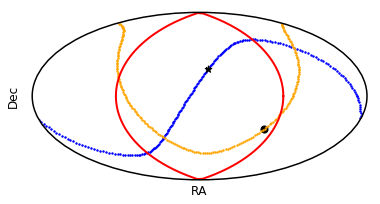

In [69]:

def define_points_at_angle(angular_separation,phi0,theta0,resolution=200):
    """define a set of points at fixed angular distance from a specified spherical surface point
    
    inputs
    ---------
    angular_separation : (degrees)
    phi0
    theta0
    
    requires
    ---------
    define_transformation_matrix_angles
    
    """
    phi = angular_separation*np.pi/180.
    lam = np.linspace(0.,2*np.pi,resolution)
    phip = np.pi/2. - phi
    cvals = [np.sin(phip),np.cos(phip)*np.cos(lam),np.cos(phip)*np.sin(lam)]
    x1,x2 = np.arctan2(cvals[1],cvals[0]),np.arctan2(cvals[2],np.sqrt(cvals[0]*cvals[0]+cvals[1]*cvals[1]))
    Bprime = define_transformation_matrix_angles(phi0*np.pi/180.,theta0*np.pi/180.,0.)
    x1b,x2b = rotate_arbitrary(x1,x2,Bprime)
    return x1b,x2b



lmcl,lmcb = -79,-32.75
x1,x2 = define_points_at_angle(90.,0.,0.,resolution=200)
x1b,x2b = define_points_at_angle(90.,lmcl,lmcb,resolution=200)

indx = 80
x1d,x2d = define_points_at_angle(90.,-x1b[indx]*180./np.pi,x2b[indx]*180./np.pi,resolution=200)
print(x1[0],x2[0])



ax = plt.subplot(111, projection="aitoff")
ax.plot(x1,x2,color='red')
ax.scatter(x1b,x2b,color='blue',s=2.)
#ax.scatter(x1c,x2c,color='green',s=2.)
ax.scatter(-lmcl*np.pi/180.,lmcb*np.pi/180.,color='black',s=50.)

ax.scatter(x1d,x2d,color='orange',s=2.)
ax.scatter(x1b[indx],x2b[indx],color='black',s=50.,marker='*')




ax.set_xlabel('RA',size=12)
ax.set_ylabel('Dec',size=12)
ax.set_xticklabels(())
ax.set_yticklabels(())

In [4]:
'''
# get the rr lyrae FROM gaia
# how many is this returning?

SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.best_class_name,variables.best_class_score,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_classifier_result AS variables 
    ON variables.source_id = gaia.source_id


'''

# RR Lyrae from vari_classifier_result
GRRV = np.genfromtxt('gaia_allvariable.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "best_class_name","best_class_score","teff_val","a_g_val"),\
                             'formats': ('S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')



print(np.unique(GRRV["best_class_name"]))



[b'ACEP' b'ARRD' b'CEP' b'DSCT_SXPHE' b'MIRA_SR' b'RRAB' b'RRC' b'RRD'
 b'T2CEP']


In [5]:
'''

# just from rrlyrae table: specific object study

SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.metallicity,variables.best_classification,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_rrlyrae AS variables 
    ON variables.source_id = gaia.source_id

'''

# RR Lyrae from specific object studies (SOS)
GRRL = np.genfromtxt('varirrlyrae.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "metallicity","best_class","teff_val","a_g_val","ebv"),\
                             'formats': ('S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')





In [6]:
print(GRRV[GRRV['best_class_name']==b'RRAB'].size)
print(GRRL[GRRL['best_class']==b'RRab'].size)

162469
98026


Text(0, 0.5, 'Distance (kpc)')

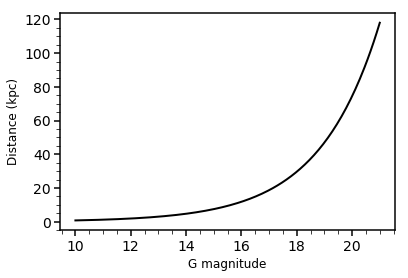

In [7]:
zeropoint = 0.64 # this is M_G from Iorio 2018
exdistance = np.linspace(10.,21.,200)


extestdistance =  10.**(((exdistance-zeropoint)/5) - 2.)

plt.plot(exdistance,extestdistance,color='black')
plt.xlabel('G magnitude',size=12)
plt.ylabel('Distance (kpc)',size=12)



In [8]:
grrltypes = GRRL["gsource_id"][(GRRL['best_class']==b'RRab')]
grrvtypes = GRRV["gsource_id"][(GRRV['best_class_name']==b'RRAB')]

ttypes = np.concatenate([grrltypes,grrvtypes])
ttype = np.array([d.decode() for d in np.unique(ttypes)])
print(ttypes.size,ttype.size)

260495 180553


In [9]:
rrls1 = np.where((GRRL['best_class']==b'RRab')\
                 & (np.isfinite(GRRL['pmra'])) & (np.isfinite(GRRL['pmdec'])))[0]

print(rrls1.size)

rrls2 = np.where((GRRV['best_class_name']==b'RRAB'))[0]

print(rrls2.size)

# this number matches the Holl result.
# do a source_id comp

uni_ids,uni_indx = np.unique(np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1]]),return_index=True)
#print(uni_ids)
print(uni_ids.size)
# this is not the number from Iorio: 228853. Why?
# need to pull out the mis-identified ones, probably...i.e. Cheng+ 2019





94875
162469
178494


In [10]:
#print(uni_indx)

all_ra  = np.concatenate([GRRV['ra'][rrls2],GRRL['ra'][rrls1]])[uni_indx]
all_dec = np.concatenate([GRRV['dec'][rrls2],GRRL['dec'][rrls1]])[uni_indx]
all_mag = np.concatenate([GRRV['phot_g_mean_mag'][rrls2],GRRL['phot_g_mean_mag'][rrls1]])[uni_indx]
all_plax = np.concatenate([GRRV['parallax'][rrls2],GRRL['parallax'][rrls1]])[uni_indx]
all_eplax = np.concatenate([GRRV['parallax_error'][rrls2],GRRL['parallax_error'][rrls1]])[uni_indx]
all_pmra = np.concatenate([GRRV['pmra'][rrls2],GRRL['pmra'][rrls1]])[uni_indx]
all_pmdec = np.concatenate([GRRV['pmdec'][rrls2],GRRL['pmdec'][rrls1]])[uni_indx]
all_epmra = np.concatenate([GRRV['pmra_error'][rrls2],GRRL['pmra_error'][rrls1]])[uni_indx]
all_epmdec = np.concatenate([GRRV['pmdec_error'][rrls2],GRRL['pmdec_error'][rrls1]])[uni_indx]
all_radvel = np.concatenate([GRRV['radial_velocity'][rrls2],GRRL['radial_velocity'][rrls1]])[uni_indx]
all_metal = np.concatenate([GRRV['radial_velocity'][rrls2]*np.nan,GRRL['metallicity'][rrls1]])[uni_indx]
all_ids = np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1]])[uni_indx]

print(all_ra.size)



178494


In [5]:
f = open('rrl_clean_rrab-result.csv','r')


headertmp = f.readline().split(',')
header = [head.strip('\n') for head in headertmp]
print(header)

RRL = {}
for head in header: RRL[head] = []

stringvals = ['name','phot_variable_flag','source_id']
    
for line in f:
    splitline = line.split(',')
    #print(splitline)
    for ih,head in enumerate(header):
        
        if head in stringvals:
            RRL[head].append(splitline[ih].strip('\n'))
        
        else:
            try:
                RRL[head].append(float(splitline[ih].strip('\n')))
            except:
                RRL[head].append(np.nan)

for head in header: 
    RRL[head] = np.array(RRL[head])




['name', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_tra

[180, -180, -90, 90]

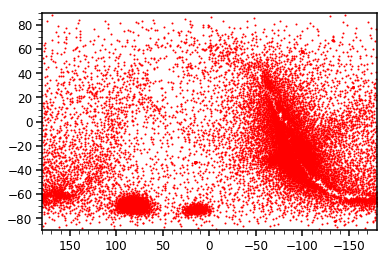

In [6]:
tmpra = RRL['ra']
tmpra[tmpra>180.]-=360.
plt.scatter(RRL['ra'][::10],RRL['dec'][::10],color='red',s=1.)
plt.axis([180,-180,-90,90])


In [7]:
RRL['name'].size

204677

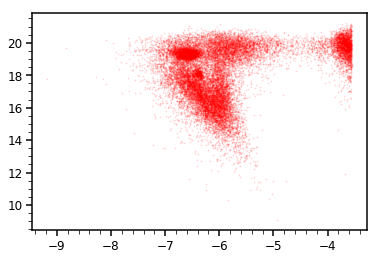

In [169]:
plt.scatter(np.log10(RRL['dist'][::10]),RRL['phot_g_mean_mag'][::10],color='red',s=1.,alpha=0.1)

In [170]:
#print(all_ra.size)
print(RRL['name'].size)
print(np.unique(RRL['name']).size)

uni,indx,cnt = np.unique(RRL['name'],return_index=True,return_counts=True)
# use [cnt==1] as a filter.
print(uni[cnt==1])

# make the templates for rejection
keep = np.zeros(RRL['name'].size,dtype='int')
keep[indx] = 1

# reject on quality: must be pretty close in position and ruwe
indx = np.where((np.log10(RRL['dist'])<-5) & (RRL['ruwe']<1.4))[0]
keep2 = np.zeros(RRL['name'].size,dtype='int')
keep2[indx] = 1

keep*=keep2

#for indx in range(0,keep.size):
#    if RRL['name'][indx] in uni[cnt==1]: keep[indx] = 1

print(np.nansum(keep),keep.size)

204677
178460
['0' '1' '10' ... '99997' '99998' '99999']
138995 204677


In [171]:
for head in header: 
    #print(head)
    if head not in ['name','designation','source_id']:
        RRL[head] = np.array(RRL[head][keep==1]).astype('float')
    else:
        RRL[head] = np.array(RRL[head][keep==1])
 
print(RRL['name'])

['0' '1' '2' ... '178491' '178492' '178493']


In [172]:
decoded_names = np.array([int((RRL['name'][x]).strip('S')) for x in range(0,RRL['name'].size)])

print(decoded_names.size)

138995


In [176]:
cols = ['dr2','gmag','dist','e_dist','ra','dec','pmra','pmra_error','pmdec','pmdec_error',\
       'glon','glat','pmGlon','pmGlon_error','pmGlat','pmGlat_error','Lambda','Beta',\
       'pmL','pmL_error','pmB','pmB_error','vl','vl_error','vb','vb_error','SOS','PS1',\
       'VC','cat','sample']

dtype = ['f8' for d in range(0,len(cols))]
dtype[0] = 'S20'
for i in range(-5,0):
    dtype[i] = 'S20'

print(len(cols),len(dtype))
usecols = [d for d in range(0,28)]
    
R20 = np.genfromtxt('Ramos20Table.txt',\
                   names=cols,dtype=dtype,usecols=usecols)




31 31


In [174]:
#'name' is the index of the all_ra/all_dec coordinate (match against all_ids)
print(RRL['name'])
print(all_ids[decoded_names])
print(decoded_names.size)

xys, x_inds, y_inds = np.intersect1d(R20['dr2'], all_ids[decoded_names], return_indices=True)
print(xys.size,y_inds.size,x_inds.size)

# need to properly index this...
print(all_ids[decoded_names][x_inds].size)

['0' '1' '2' ... '178491' '178492' '178493']


NameError: name 'all_ids' is not defined

In [175]:
plt.scatter(R20['ra'][x_inds], R20['dec'][x_inds],color='black',s=1.)



NameError: name 'x_inds' is not defined

In [30]:
LMCa = 192.85948 * np.pi/180.
LMCd = 27.12825 * np.pi/180.
LMCda = 175. * np.pi/180.
LMCdd = -40. * np.pi/180.

LMCa = 81.28 * np.pi/180.
LMCd = -69.78 * np.pi/180.
#/np.cos(LMCd)
LMCda = (81.28 + 1.7608) * np.pi/180.
LMCdd = (-69.78 + 0.308) * np.pi/180.

# pick a random spot
#LMCda = 130. * np.pi/180.
#LMCdd = -59. * np.pi/180.

# define the RA and DEC positions for the LMC, use the pm_ra and pm_dec values
LMCa = 81.28 * np.pi/180.
LMCd = -69.78 * np.pi/180.
LMCda = (81.28 + 1.7608/np.cos(LMCd)) * np.pi/180.
LMCdd = (-69.78 + 0.308) * np.pi/180.


# use 
LMCl,LMCb = rotate_galactic(LMCa,LMCd)
tmp1,tmp2 = rotate_velocities(LMCa,LMCd,1.7608,0.308)
#tmp1,tmp2 = rotate_velocities(LMCa,LMCd,1.9103,0.2292)

GtLMC = define_transformation_matrix(LMCl,LMCb,LMCl+tmp1,LMCb+tmp2,start=0)

print('l={0:3.2f}, b={1:3.2f}, pm_l={2:3.2f}, pm_b={3:3.2f}'.format((180./np.pi)*LMCl,(180./np.pi)*LMCb,tmp1,tmp2))

#LMCda = LMCa+tmp1[0]
#LMCdd = LMCd+tmp2[0]

#LMCda = -80.*np.pi/180.
#LMCdd = 0.

rLMC = [np.cos(LMCa)*np.cos(LMCd),np.sin(LMCa)*np.cos(LMCd),np.sin(LMCd)]
rdLMC = [np.cos(LMCda)*np.cos(LMCdd),np.sin(LMCda)*np.cos(LMCdd),np.sin(LMCdd)]

cLMC = np.cross(rLMC,rdLMC)
ltLMC = np.arctan2(cLMC[1],cLMC[0])
btLMC = np.arctan2(cLMC[2],np.sqrt(cLMC[0]*cLMC[0]+cLMC[1]*cLMC[1]))
print(ltLMC,btLMC)

l=-79.54, b=-32.75, pm_l=-0.62, pm_b=1.68
1.2800142377222277 0.34979233667015536


In [22]:
phi = -90.*np.pi/180.
theta = (90.-(180./np.pi)*btLMC)*np.pi/180.
psi = ((180./np.pi)*ltLMC+90)*np.pi/180.

D = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
C = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
B = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

A = np.dot(D,np.dot(C,B))#.T
print(A)


[[ 9.82534097e-02  3.28316047e-01 -9.39443900e-01]
 [-9.58019942e-01  2.86701570e-01  5.75243482e-17]
 [ 2.69340041e-01  9.00005991e-01  3.42702727e-01]]


In [31]:
print(GtLMC)

[[ 0.03619896 -0.9993446   0.        ]
 [-0.22105329 -0.00800715  0.97522886]
 [-0.9745897  -0.03530227 -0.22119826]]


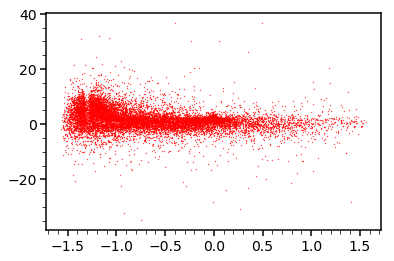

In [24]:
plt.scatter(btrans[::10],multrans[::10],color='red',s=0.1)
#plt.axis([-5.,5.,-5.,5.])



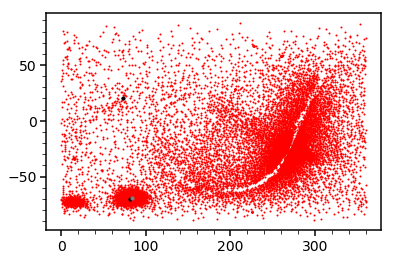

In [25]:
plt.scatter(RRL['ra'][::10],RRL['dec'][::10],color='red',s=1.)
#alpha,delta = 192.85948,27.12825
#plt.scatter([alpha],[delta],color='black',s=10.)
plt.scatter([81.28],[-69.78],color='black',s=10.)
plt.scatter([81.28+1.7608],[-69.78+0.308],color='grey',s=10.)
#plt.scatter([175.],[-40.],color='blue',s=10.)
#plt.scatter([130.],[-59.],color='blue',s=10.)



plt.scatter([ltLMC*180./np.pi],[btLMC*180./np.pi],color='black',s=10.)





In [26]:
# check for RRab agreement between the two systems


xy, x_ind, y_ind = np.intersect1d(RRL['source_id'], ttype, return_indices=True)
print(ttype.size,y_ind.size,x_ind.size)

180553 136036 136036


In [27]:

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.17 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 20 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


c = coord.SkyCoord(ra              = RRL['ra']    * u.deg,\
                   dec             = RRL['dec']   * u.deg,\
                   distance        = np.ones(RRL['ra'].size)  * u.kpc,\
                   pm_ra_cosdec    = RRL['pmra']  * u.mas/u.yr,\
                   pm_dec          = RRL['pmdec'] * u.mas/u.yr,\
                   radial_velocity = np.zeros(RRL['pmdec'].size)  * u.km/u.s)
        

RRLcartesian = c.transform_to(gc_frame)
RRLcoords  = c.transform_to('galactic')
RRLsgr  = c.transform_to(Sagittarius)
print(RRLsgr.Lambda.size)

"""
template = np.empty(RRLsgr.Lambda.size,dtype='bool')
template.fill(True)
template[x_inds] = False
print(template)
RRLsgr  = c[template].transform_to(Sagittarius)

print(RRLsgr.Lambda.size)

RRLcartesian = c[template].transform_to(gc_frame)
RRLcoords    = c[template].transform_to('galactic')
"""
#RRLcoords[np.array(RRLcoords) > 180] -= 360.

138995


"\ntemplate = np.empty(RRLsgr.Lambda.size,dtype='bool')\ntemplate.fill(True)\ntemplate[x_inds] = False\nprint(template)\nRRLsgr  = c[template].transform_to(Sagittarius)\n\nprint(RRLsgr.Lambda.size)\n\nRRLcartesian = c[template].transform_to(gc_frame)\nRRLcoords    = c[template].transform_to('galactic')\n"

In [28]:
import dustmaps

from dustmaps.sfd import SFDQuery



coords = coord.SkyCoord(RRLcoords.l, RRLcoords.b, unit='deg', frame='galactic')
sfd = SFDQuery()
extinctions = 2.27*sfd(coords)

zeropoint = 0.64 # this is M_G from Iorio 2018

# can't remember if phot_g_mean_mag is corrected or not?

#dist = 10.**(((-zeropoint)/5) - 2.)
#distV = 10.**(((GRRV['phot_g_mean_mag']-zeropoint)/5) - 2.)

#alldist2=  10.**(((RRLD['Gmag']-extinctions-zeropoint)/5) - 2.)
alldist3=  10.**(((RRL['phot_g_mean_mag']-extinctions-zeropoint)/5) - 2.)





In [29]:
all_ids[decoded_names].size
RRLsgr.Beta.size


138995

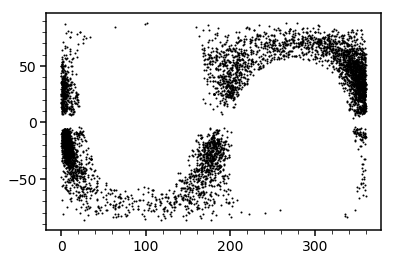

In [30]:
plt.scatter(RRLcoords.l[y_inds], RRLcoords.b[y_inds],color='black',s=1.)



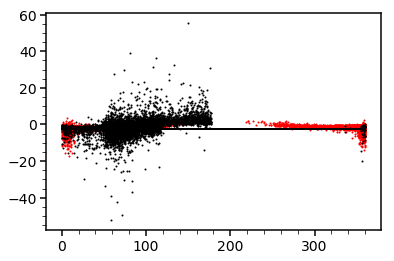

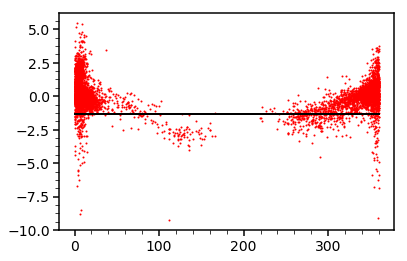

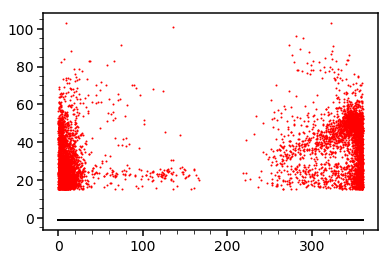

In [31]:
sgrselec= (np.abs(np.array(RRLsgr.Beta))<10.) &\
((np.abs(np.array(RRLsgr.Lambda))<90.) |\
(np.abs(np.array(RRLsgr.Lambda))>250.)) &\
(np.sqrt((RRL['pmra']+2.69)**2. + (RRL['pmdec']+1.35)) < 3.0) &\
(alldist3 > 15.)

#plt.scatter(RRLcoords.l[sgrselec], RRLcoords.b[sgrselec],color='red',s=1.)
plt.figure()
plt.scatter(RRLcoords.l[sgrselec], RRLcoords.pm_l_cosb[sgrselec],color='red',s=1.)
plt.plot([0.,360.],[-2.69,-2.69],color='black')

plt.scatter(RRLcoords.l[x_inds], RRLcoords.pm_l_cosb[x_inds],color='black',s=1.)




plt.figure()
plt.scatter(RRLcoords.l[sgrselec], RRLcoords.pm_b[sgrselec],color='red',s=1.)
plt.plot([0.,360.],[-1.35,-1.35],color='black')

plt.figure()
plt.scatter(RRLcoords.l[sgrselec], alldist3[sgrselec],color='red',s=1.)
plt.plot([0.,360.],[-1.35,-1.35],color='black')




#-2.69,-1.35

## Try some selections

In [32]:
# set up the blank array
# 0 will accept, 1 will fail
masterlist = np.empty(RRLcoords.l.size,dtype='bool')
masterlist.fill(False)
masterlist.fill(True)
print(np.sum(masterlist))

138995


In [33]:
# select only RRAB
masterlist[x_ind] = False
print(len(masterlist)-np.nansum(masterlist))

136036


In [34]:
# select only RRAB
masterlist[y_inds] = True
print(np.nansum(masterlist))
print(len(masterlist)-np.nansum(masterlist))

11310
127685


In [35]:
# remove Sgr
#masterlist[sgrselec] = True
#print(len(masterlist)-np.nansum(masterlist))

In [36]:
# eliminate extinction values

w = np.where(extinctions>1.)
masterlist[w] = True
print(len(masterlist)-np.nansum(masterlist))

89042


150
1461
51753


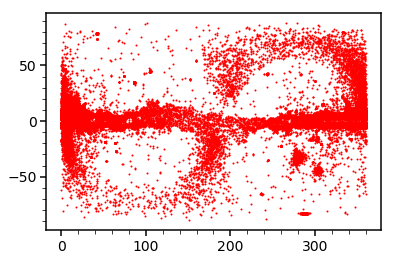

In [67]:
gcfile = '/Users/mpetersen/Notebooks/Dynamics/Shells/data/Vasiliev19.txt'

In = np.genfromtxt(gcfile,skip_header=61,delimiter=';')
ragc    = In[:,2]
decgc   = In[:,3]
distgc  = In[:,4]
losgc   = In[:,5]
pmragc  = In[:,6]
pmdecgc = In[:,7]
rvalgc = In[:,12]

gc_l,gc_b = rotate_galactic(ragc*np.pi/180.,decgc*np.pi/180.)
gc_pml,gc_pmb = rotate_velocities(ragc*np.pi/180.,decgc*np.pi/180.,pmragc,pmdecgc)

print(ragc.size)

removed= 0

for indx,n in enumerate(ragc):
    #print(l[indx])
    msdist = haversine(RRL['ra'], RRL['dec'],ragc[indx],decgc[indx])
    
    # half follow the Iorio & Belokurov selection...
    w = np.where(msdist<3.*rvalgc[indx]/60.)
    #print(ragc[indx],len(w[0]))

    masterlist[w] = True
    removed += w[0].size
    
print(removed)
print(np.sum(masterlist))
plt.scatter(RRLcoords.l[masterlist], RRLcoords.b[masterlist],color='red',s=1.)

In [38]:
satfile = '/Users/mpetersen/Desktop/StudentProjects/Victoria/satellites_mcconnachie_edr3.txt'

In2 = np.genfromtxt(satfile,skip_header=1,dtype='S20')

name = In2[:,16]
print(name)

In = np.genfromtxt(satfile,skip_header=1)

l    = In[:,6]
b    = In[:,7]

for indx,n in enumerate(name):
    #print(l[indx])
    msdist = haversine(np.array(RRLcoords.l), np.array(RRLcoords.b),l[indx],b[indx])
    
    # half follow the Iorio & Belokurov selection...
    if ((n==b'Sextans1') | (n==b'Sculptor') | (n==b'Fornax') | (n==b'Draco') | (n==b'UrsaMinor')):
        w = np.where(msdist<1.)
        print(n,len(w[0]))
    else:
        w = np.where(msdist<0.5)
    masterlist[w] = True
    

[b'Antlia2' b'Aquarius2' b'Bootes1' b'Bootes2' b'CanesVenatici1'
 b'CanesVenatici2' b'Carina' b'Carina2' b'Carina3' b'Columba1'
 b'ComaBerenices' b'Crater2' b'Draco' b'Draco2' b'Eridanus2' b'Fornax'
 b'Grus1' b'Grus2' b'Hercules' b'Horologium1' b'Horologium2' b'Hydra2'
 b'Hydrus1' b'Leo1' b'Leo2' b'Leo4' b'Leo5' b'LeoT' b'Phoenix' b'Phoenix2'
 b'Pisces2' b'Reticulum2' b'Reticulum3' b'Sagittarius2' b'Sculptor'
 b'Segue1' b'Segue2' b'Sextans1' b'Triangulum2' b'Tucana2' b'Tucana3'
 b'Tucana4' b'Tucana5' b'UrsaMajor1' b'UrsaMajor2' b'UrsaMinor'
 b'Willman1']
b'Draco' 208
b'Fornax' 16
b'Sculptor' 299
b'Sextans1' 28
b'UrsaMinor' 80


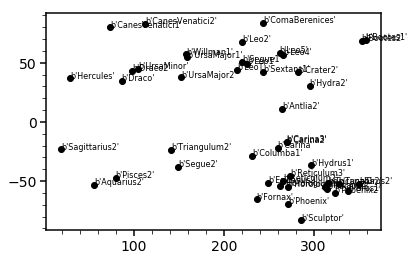

In [39]:
plt.scatter(l,b,color='black')

for gnum,gname in enumerate(name):
    plt.text(l[gnum],b[gnum],gname,color='black',size=8)

51753


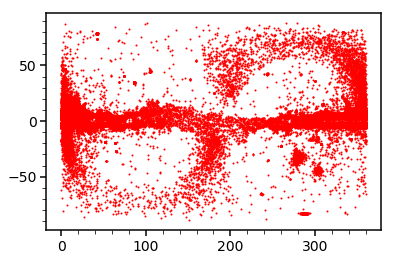

In [40]:
print(np.sum(masterlist))
plt.scatter(RRLcoords.l[masterlist], RRLcoords.b[masterlist],color='red',s=1.)

In [41]:
RRLcoords.l[~masterlist].size

87242

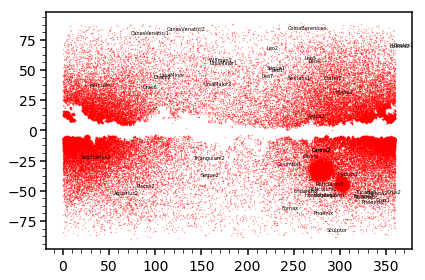

In [42]:
plt.scatter(RRLcoords.l[~masterlist], RRLcoords.b[~masterlist],color='red',s=.1,alpha=0.5)
for gnum,gname in enumerate(name):
    plt.text(l[gnum],b[gnum],gname.decode(),color='black',size=5)
    
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/clean_rrl.png',dpi=300)

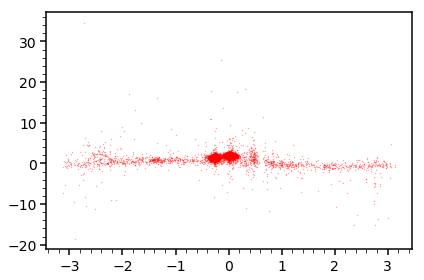

In [43]:
w = np.where((alldist3>50.) & ~masterlist & (np.abs(btrans)<20.*np.pi/180.))

plt.scatter(ltrans[w], multrans[w],color='red',s=.1,alpha=0.5)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/clean_rrl.png',dpi=300)

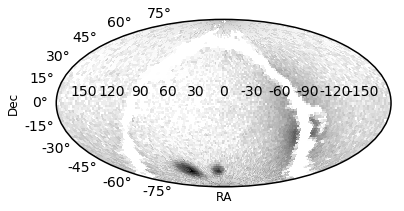

In [49]:
ddeg = 2.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

ratranspose = RRL['ra']
ratranspose[ratranspose>180]-=360.

X,Y,img_Z = sky_hist_2d(ratranspose[~masterlist],RRL['dec'][~masterlist],ravals,decvals)

#X,Y,img_Z = sky_hist_2d(RRL['ra'],RRL['dec'],ravals,decvals)


ax = plt.subplot(111, projection="aitoff")
ax.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z[:,::-1]),cmap=cm.Greys)
ax.set_xlabel('RA',size=12)
ax.set_ylabel('Dec',size=12)
_ = ax.set_xticklabels(np.arange(150,-151,-30))
#ax.set_xlim(np.pi,-np.pi)



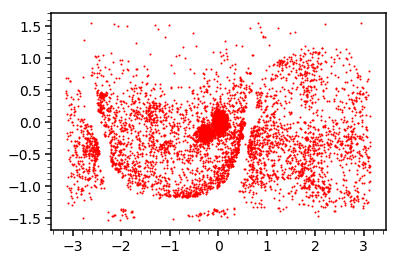

In [50]:

ltrans,btrans = rotate_arbitrary(RRL['ra']*np.pi/180.,RRL['dec']*np.pi/180.,A)
multrans,mubtrans = rotate_velocities_arbitrary(RRL['ra']*np.pi/180.,RRL['dec']*np.pi/180.,RRL['pmra'],RRL['pmdec'],A)


w = (~masterlist) & (alldist3>50)
plt.scatter(ltrans[w],btrans[w],color='red',s=1.)




In [51]:
c = coord.SkyCoord(ra              = RRL['ra']    * u.deg,\
                   dec             = RRL['dec']   * u.deg,\
                   distance        = alldist3  * u.kpc,\
                   pm_ra_cosdec    = RRL['pmra']  * u.mas/u.yr,\
                   pm_dec          = RRL['pmdec'] * u.mas/u.yr,\
                   radial_velocity = np.zeros(RRL['pmdec'].size)  * u.km/u.s)
        

RRLcartesian = c.transform_to(gc_frame)
RRLcoords  = c.transform_to('galactic')



In [52]:
print(np.nanmax(RRLcoords.l))

359d59m59.9302s


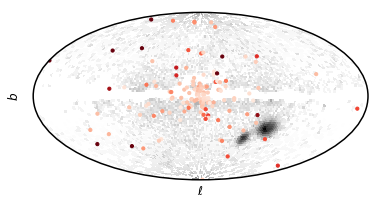

In [114]:
ddeg = 2.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

tmpl = np.array(RRLcoords.l)
tmpl[tmpl>180]-=360.

w = (~masterlist) & (alldist3>25.)

X,Y,img_Z = sky_hist_2d(tmpl[w],np.array(RRLcoords.b)[w],ravals,decvals)

#X,Y,img_Z = sky_hist_2d(RRL['ra'],RRL['dec'],ravals,decvals)


ax = plt.subplot(111, projection="aitoff")
ax.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z[:,::-1]),cmap=cm.Greys)
ax.set_xlabel('$\ell$',size=12)
ax.set_ylabel('$b$',size=12)
_ = ax.set_xticklabels(np.arange(150,-151,-30))

ax.scatter(gc_l,gc_b,color=cm.Reds(distgc/45.,1.),s=10)
ax.set_xticklabels(())
ax.set_yticklabels(())


plt.savefig('figures/galactic_clean_rr_gt30kpc.png',dpi=300)
#ax.set_xlim(np.pi,-np.pi)

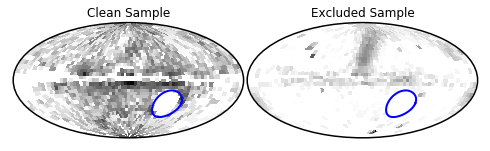

In [203]:


#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

#X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)
#wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)

tmpl = np.array(RRLcoords.l)
tmpl[tmpl>180]-=360.

msdist = haversine(tmpl,np.array(RRLcoords.b),-70,-35,deg=True)
w = (~masterlist) & (alldist3>35.)&(msdist>20)


X,Y,img_ZL = sky_hist_2d(tmpl[w],np.array(RRLcoords.b)[w],ravals,decvals)


tmpl = np.array(RRLcoords.l)
tmpl[tmpl>180]-=360.

w = (masterlist) & (alldist3>35.)&(msdist>20)

X,Y,img_ZM = sky_hist_2d(tmpl[w],np.array(RRLcoords.b)[w],ravals,decvals)




fig = plt.figure(figsize=(6.5,2))
ax1 = fig.add_axes([0.0,0.05,0.5,0.8], projection="aitoff")
ax2 = fig.add_axes([0.5,0.05,0.5,0.8], projection="aitoff")

#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
ax1.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,np.log10(img_ZL),cmap=cm.Greys)
ax1.plot(x1b,x2b,color='blue')
ax2.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,np.log10(img_ZM),cmap=cm.Greys)
ax2.plot(x1b,x2b,color='blue')


ax1.set_title('Clean Sample',size=12)
ax2.set_title('Excluded Sample',size=12)


for ax in [ax1,ax2]:
    ax.set_xticklabels(())
    ax.set_yticklabels(())

#ax.set_xlabel('$\ell$',size=12)
#ax.set_ylabel('$b$',size=12)

plt.savefig('figures/trueLMClocation.png',dpi=300)

[-5, 5, -5, 5]

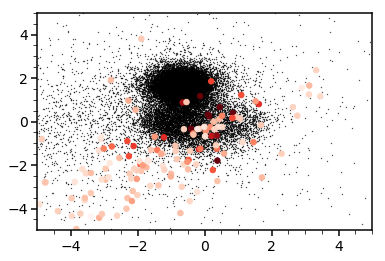

In [79]:
plt.scatter(np.array(RRLcoords.pm_l_cosb)[w],np.array(RRLcoords.pm_b)[w],color='black',s=0.1)

plt.scatter(gc_pml,gc_pmb,color=cm.Reds(distgc/45.,1.),s=30)



plt.axis([-5,5,-5,5])
#plt


Text(0, 0.5, 'z (kpc)')

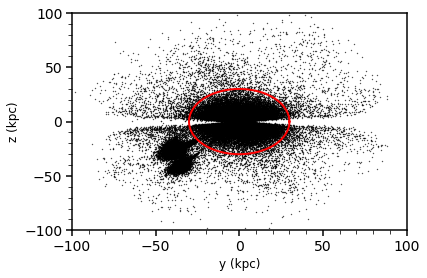

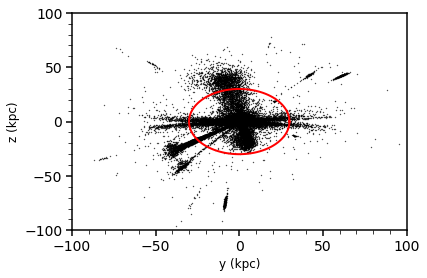

In [117]:
rcircle = 30.
tcircle = np.linspace(0.,2.*np.pi,100)

plt.scatter(RRLcartesian.y[~masterlist],RRLcartesian.z[~masterlist],color='black',s=0.1)
plt.plot(rcircle*np.cos(tcircle),rcircle*np.sin(tcircle),color='red')
plt.axis([-100,100,-100,100])
plt.xlabel('y (kpc)',size=12)
plt.ylabel('z (kpc)',size=12)

plt.figure()
plt.scatter(RRLcartesian.y[masterlist],RRLcartesian.z[masterlist],color='black',s=0.1)
plt.plot(rcircle*np.cos(tcircle),rcircle*np.sin(tcircle),color='red')
plt.axis([-100,100,-100,100])
plt.xlabel('y (kpc)',size=12)
plt.ylabel('z (kpc)',size=12)


84617
84596


[-10.0, 10.0, -10.0, 10.0]

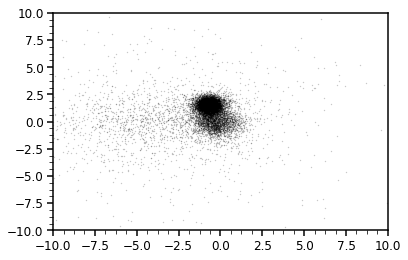

In [70]:

G = np.genfromtxt('rrl_edr3_galactic_extraclean_rrab_ids.txt',skip_header=1)


#G = np.genfromtxt('rrl_edr3_galactic_only.txt',skip_header=1)

glon = G[:,0]
glat = G[:,1]
dist = G[:,2]
pml = G[:,3]
pmb = G[:,4]
vlos = G[:,5]
ids = G[:,6]
gmag = G[:,7]



print(vlos.size)

goodvals = (~np.isnan(dist) | ~np.isnan(pml) | ~np.isnan(pmb) | ~np.isnan(dist) | ~np.isnan(glon) | ~np.isnan(glat))


glon = glon[goodvals]
glat = glat[goodvals]
dist = dist[goodvals]
pml  =  pml[goodvals]
pmb  =  pmb[goodvals]
vlos = vlos[goodvals]
ids  = ids[goodvals]

gmag  = gmag[goodvals]


print(vlos.size)



w = np.where(dist > 50.)
plt.scatter(pml[w],pmb[w],color='black',s=.1,alpha=0.3)
plt.axis([-10.,10.,-10.,10.])


1.5707963267948966 0.0


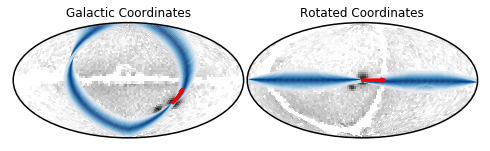

In [168]:

fig = plt.figure(figsize=(6.5,2))
ax1 = fig.add_axes([0.0,0.05,0.5,0.8], projection="aitoff")
ax2 = fig.add_axes([0.5,0.05,0.5,0.8], projection="aitoff")


lmcl,lmcb = -79,-32.75
lmcpl,lmcpb = -0.62,1.68
x1,x2 = define_points_at_angle(90.,0.,0.,resolution=200)

# define the 90degree curve from the LMC
x1b,x2b = define_points_at_angle(90.,lmcl,lmcb,resolution=200)

indx = 80
print(x1[0],x2[0])



#ax = plt.subplot(111, projection="aitoff")

ddeg = 3.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.


glontmp = glon
glontmp[glontmp>180] -= 360.
w = np.where(dist>20)
X,Y,img_Z = sky_hist_2d(glontmp[w],glat[w],ravals,decvals)


ax1.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z[:,::-1]),cmap=cm.Greys)


for indx in range(80,100):
    x1d,x2d = define_points_at_angle(90.,-x1b[indx]*180./np.pi,x2b[indx]*180./np.pi,resolution=500)
    ax1.scatter(x1d,x2d,color=cm.Blues_r(np.abs(indx-90)/10.),s=4.,alpha=0.1)

ax1.arrow(-lmcl*np.pi/180.,lmcb*np.pi/180.,\
         -10.*lmcpl*np.pi/180.,10.*lmcpb*np.pi/180.,color='red',lw=3.,head_width=0.05)



GtLMC = define_transformation_matrix(LMCl,LMCb,LMCl+tmp1,LMCb+tmp2,start=-35.)
ltrans,btrans = rotate_arbitrary(glon*np.pi/180.,glat*np.pi/180.,GtLMC)

X,Y,img_Z = sky_hist_2d(ltrans[w]*180./np.pi,btrans[w]*180./np.pi,ravals,decvals)


ax2.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z[:,::-1]),cmap=cm.Greys)


for indx in range(80,100):
    ltest = np.linspace(-np.pi,np.pi,500)
    btest = np.sin(ltest)*1.5*(indx-90)*np.pi/180.
    ax2.scatter(ltest,btest,color=cm.Blues_r(np.abs(indx-90)/10.),s=4.,alpha=0.1)

ax2.arrow(0.,0.,\
         -50.*lmcpl*np.pi/180.,0.,color='red',lw=3.,head_width=0.05)



ax1.set_title('Galactic Coordinates',size=12)
ax2.set_title('Rotated Coordinates',size=12)


for ax in [ax1,ax2]:
    ax.set_xticklabels(())
    ax.set_yticklabels(())

#ax.set_xlabel('$\ell$',size=12)
#ax.set_ylabel('$b$',size=12)

plt.savefig('figures/lmc_overlay_tracks.png',dpi=300)





-1.3881573026272656 -0.5716450895980933
[[ 0.15644341 -0.81402246 -0.55936829]
 [-0.16031338 -0.57975959  0.79886071]
 [-0.9745897  -0.03530227 -0.22119826]]


[-5, 5, -5, 5]

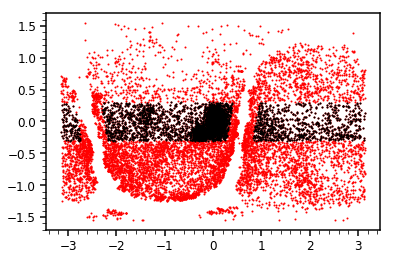

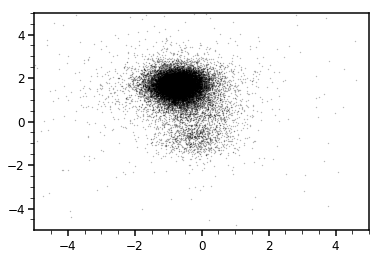

In [138]:

# use 
LMCa = 81.28 * np.pi/180.
LMCd = -69.78 * np.pi/180.
LMCl,LMCb = rotate_galactic(LMCa,LMCd)
tmp1,tmp2 = rotate_velocities(LMCa,LMCd,1.7608,0.308)
#tmp1,tmp2 = rotate_velocities(LMCa,LMCd,1.9103,0.2292)
print(LMCl,LMCb)

# how does the plane look different from the Galactic Centre? please draw a picture tomorrow
# also put the Zaritsky stars on here! -> galactic, ->LMC.
# what is the Nidever rotation plane?

GtLMC = define_transformation_matrix(LMCl,LMCb,LMCl+tmp1,LMCb+tmp2,start=-35.)
print(GtLMC)

ltrans,btrans = rotate_arbitrary(glon*np.pi/180.,glat*np.pi/180.,GtLMC)
#multrans,mubtrans = rotate_velocities_arbitrary(RRL['ra']*np.pi/180.,RRL['dec']*np.pi/180.,RRL['pmra'],RRL['pmdec'],A)


fig = plt.figure(figsize=(6.5,2))
ax1 = fig.add_axes([0.0,0.05,0.5,0.8], projection="aitoff")
#w = (~masterlist) & (alldist3>50)
w = (dist>30)
plt.scatter(ltrans[w],btrans[w],color='red',s=1.)
w = (dist>30) & (np.abs(btrans)<0.3) & (np.abs(glat)>15.)
plt.scatter(ltrans[w],btrans[w],color='black',s=1.)




plt.figure()
# now, the idea is to define a very broad plane and look at the kinematics in the plane
w = (np.abs(btrans)<0.3) & (dist>30) & (np.abs(glat)>15.) # & (dist<55)
plt.scatter(pml[w],pmb[w],color='black',s=0.1,alpha=0.4)
plt.axis([-5,5,-5,5])

# please put Price-Whelan on here?
# correct velocities for the galactic centre?

# colour-code in circles going out from the LMC centre on the l-b plot


In [131]:
GtLMC = define_transformation_matrix(LMCl,LMCb,LMCl+tmp1,LMCb+tmp2,start=180.)
print(GtLMC)

GtLMC = define_transformation_matrix(LMCl,LMCb,LMCl+tmp1,LMCb+tmp2,start=0.)
print(GtLMC)

[[-3.61989605e-02  9.99344603e-01  1.19431090e-16]
 [ 2.21053287e-01  8.00714708e-03 -9.75228860e-01]
 [-9.74589698e-01 -3.53022710e-02 -2.21198260e-01]]
[[ 0.03619896 -0.9993446   0.        ]
 [-0.22105329 -0.00800715  0.97522886]
 [-0.9745897  -0.03530227 -0.22119826]]


In [92]:
ddeg = 2.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

X,Y,img_Z = sky_hist_2d(RRL['ra'][~masterlist],RRL['dec'][~masterlist],ravals,decvals)

#X,Y,img_Z = sky_hist_2d(RRL['ra'],RRL['dec'],ravals,decvals)


ax = plt.subplot(111, projection="aitoff")
ax.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z[:,::-1]),cmap=cm.Greys)
ax.set_xlabel('RA',size=12)
ax.set_ylabel('Dec',size=12)
_ = ax.set_xticklabels(np.arange(150,-151,-30))
#ax.set_xlim(np.pi,-np.pi)

NameError: name 'masterlist' is not defined

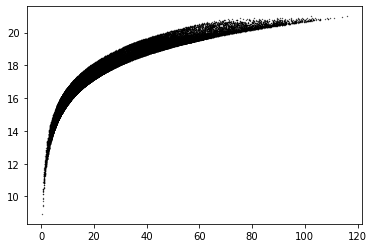

In [10]:
plt.scatter(dist,gmag,color='black',s=0.1)

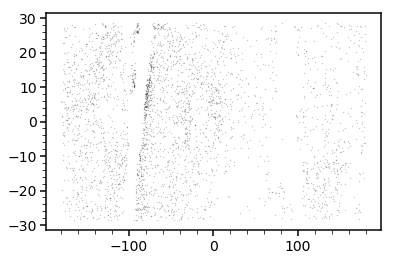

In [83]:
ltrans,btrans = rotate_arbitrary(glon*np.pi/180.,glat*np.pi/180.,A)
multrans,mubtrans = rotate_velocities_arbitrary(glon*np.pi/180.,glat*np.pi/180.,pml,pmb,A)

w = np.where((dist > 40.) & (np.abs(btrans)<0.5))
netpm = np.sqrt(pml*pml + pmb*pmb)

plt.scatter(ltrans[w]*180./np.pi,btrans[w]*180./np.pi,color='black',s=.1,alpha=0.3)




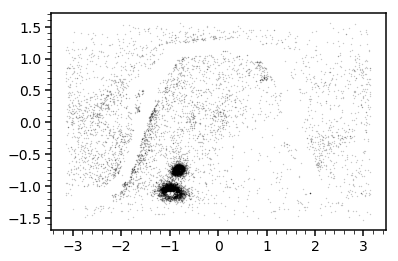

In [84]:
# something is wrong with the transformation here

w = np.where(dist > 50.)
plt.scatter(ltrans[w],btrans[w],color='black',s=.1,alpha=0.3)
#plt.axis([-10.,10.,-10.,10.])




[-10.0, 10.0, -10.0, 10.0]

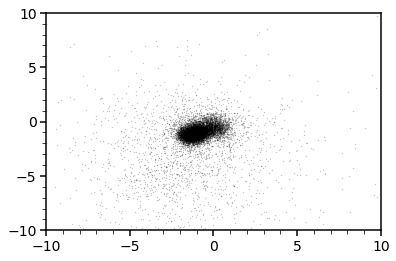

In [85]:
w = np.where(dist > 50.)
plt.scatter(multrans[w],mubtrans[w],color='black',s=.1,alpha=0.3)
plt.axis([-10.,10.,-10.,10.])



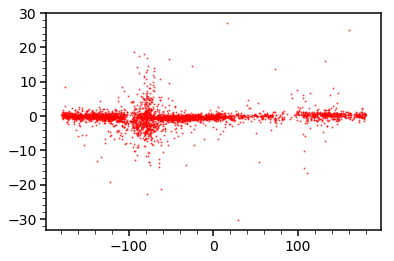

In [86]:
w = np.where((dist > 40.) & (np.abs(btrans)<0.5))
plt.scatter(ltrans[w]*180./np.pi,multrans[w],color='red',s=1.,alpha=0.6)
#plt.scatter(glon[w],glat[w],color='red',s=1.,alpha=0.6)




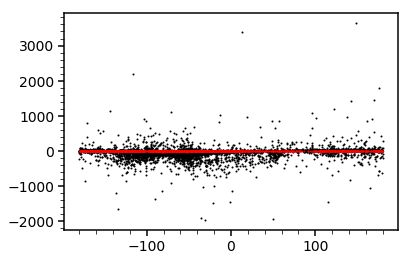

In [87]:
#w = np.where(dist > 40.)
#netpm = np.sqrt(pml*pml + pmb*pmb)

#w = np.where((dist < 10.) & (np.abs(glat)<30.))
w = np.where((dist > 40.) & (np.abs(btrans)>0.5))
plt.scatter(ltrans[w]*180./np.pi,(dist*multrans)[w],color='black',s=1.,alpha=1.)




w = np.where((dist > 40.) & (np.abs(btrans)<0.5))
plt.scatter(ltrans[w]*180./np.pi,mubtrans[w],color='red',s=1.,alpha=0.6)
#plt.scatter(glon[w],glat[w],color='red',s=1.,alpha=0.6)





#plt.axis([-90,90,-4,4])

#plt.axis([0,120,-200,200])

(-90.0, 90.0, -4.0, 4.0)

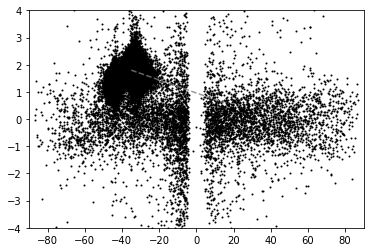

In [16]:
w = np.where(dist > 40.)
netpm = np.sqrt(pml*pml + pmb*pmb)

plt.scatter(glat[w],pmb[w],color='black',s=1.)
plt.plot([-35,15],[1.8,0.6],color='grey',linestyle='dashed',alpha=0.8)

plt.axis([-90,90,-4,4])

[-90, 90, -4, 4]

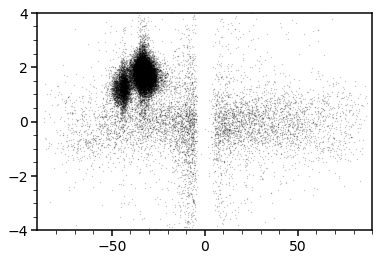

In [88]:
w = np.where(dist > 40.)
netpm = np.sqrt(pml*pml + pmb*pmb)

plt.scatter(glat[w],pmb[w],color='black',s=.1,alpha=0.3)

plt.axis([-90,90,-4,4])

In [89]:
#1910517441380.0,109665638197.2865,4475285622.079862
np.log10(109665638197.2865)

11.040070570336654

In [90]:
print(np.percentile(dist,10.))

7.07635


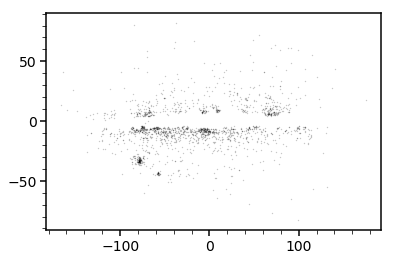

In [91]:
glon_new = glon
glon_new[glon>180] -= 360.

w = np.where(dist > 40.)

w = np.where((pml < -2.2) & (dist > 40.))



plt.scatter(glon_new[w],glat[w],color='black',s=.1,alpha=0.3)
#plt.axis([-10.,10.,-10.,10.])

In [177]:
import numpy as np


Q = np.memmap('/Users/mpetersen/Downloads/mw_lmc_mock_32_obs.dat',dtype='float32',shape=(500000,8))

mass          = Q[:,0]  # stellar mass of particles
distance      = Q[:,1]  # distance in kpc
galactic_l    = Q[:,2]  # galactic longitude in radians (translate to degrees with *(180./np.pi))
galactic_b    = Q[:,3]  # galactic latitude in radians
vlos          = Q[:,4]  # line-of-sight velocity in km/s
p_galactic_l  = Q[:,5]  # proper motion in galactic longitude in milliarcsec/yr (translate to velocity with *4.74*distance)
p_galactic_b  = Q[:,6]  # proper motion in galactic latitude in milliarcsec/yr
lmc           = Q[:,7]  # proper motion in galactic latitude in milliarcsec/yr




In [178]:
#print(np.log10(np.nansum(mass[lmc==1])))
print(np.nansum(lmc[(lmc==1) & (galactic_b>0.)])/np.nansum(lmc[lmc==1]))

0.12507766


In [179]:
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

criteria = (lmc==1)&(distance<60.)&(distance>40.)#&(netpm>.5)&(netpm<1.0)
criteria = (distance<60.)&(distance>40.)#&(netpm>.5)&(netpm<1.0)


xpos,ypos,zpos = gen_sphere_surface(32000)
print(xpos.size)

a = 0.*(np.pi/180.)
b = 40*(np.pi/180.)
c = -80.*(np.pi/180.)
cosa = np.cos(a);sina = np.sin(a)
cosb = np.cos(b);sinb = np.sin(b)
cosc = np.cos(c);sinc = np.sin(c)

eulermat = np.array([[cosa*cosb*cosc - sina*sinc,-cosc*sina - cosa*cosb*sinc,cosa*sinb],
                     [sina*cosb*cosc + cosa*sinc, cosa*cosc - cosb*sina*sinc,sina*sinb],
                     [               - sinb*cosc,                  sinb*sinc, cosb]])


tiltpts = np.dot(np.array([xpos*1.5,ypos,zpos]).T,eulermat)
xpos,ypos,zpos = tiltpts[:,0],tiltpts[:,1],tiltpts[:,2]

print(np.nanmax(xpos))
xsun = 8./40.
ypos -= xsun
print(np.nanmax(xpos))
lvals = np.arctan2(ypos,xpos)
bvals = np.arctan2(zpos,np.sqrt(xpos*xpos+ypos*ypos))


X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)






31924
1.010997443925478
1.010997443925478


Text(0, 0.5, 'galactic b')

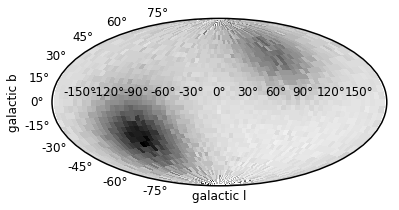

In [180]:

#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)


plt.subplot(111, projection="aitoff")
#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,img_Z/np.nanmean(img_Z),cmap=cm.Greys)


#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)

#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,1./np.cos(Y*np.pi/180.),cmap=cm.Greys,vmin=0.5,vmax=1.5)


#plt.imshow(np.log10(img_Z),origin='lower',\
#           extent=(np.nanmin(ravals),np.nanmax(ravals),np.nanmin(decvals),np.nanmax(decvals)),\
#           cmap=cm.Greys,aspect='auto')


plt.xlabel('galactic l',size=12)
plt.ylabel('galactic b',size=12)

Text(0, 0.5, 'galactic b')

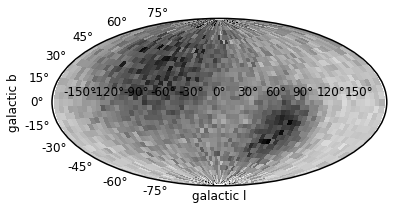

In [181]:


#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

#X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)
criteria = (lmc==0)&(distance>40.)#&(netpm>.5)&(netpm<1.0)


X,Y,img_Z = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])



plt.subplot(111, projection="aitoff")
#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,img_Z/np.nanmean(img_Z),cmap=cm.Greys)


plt.xlabel('galactic l',size=12)
plt.ylabel('galactic b',size=12)

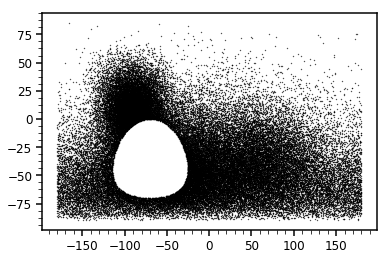

In [182]:
msdist = haversine(galactic_l*180./np.pi,galactic_b*180./np.pi,-70,-35,deg=True)
criteria = (lmc==1)&(distance>40.)&(msdist>35)
#criteria = (msdist<25)



plt.scatter(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,color='black',s=0.1)

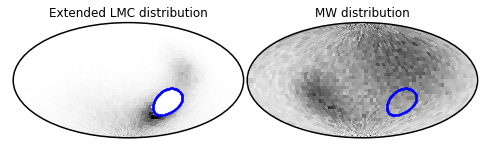

In [245]:


#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

#X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)
#wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)

msdist = haversine(galactic_l*180./np.pi,galactic_b*180./np.pi,-70,-35,deg=True)
criteria = (lmc==1)&(distance>35.)&(msdist>20)


X,Y,img_ZL = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])


criteria = (lmc==0)&(distance>35.)#&(netpm>.5)&(netpm<1.0)


X,Y,img_ZM = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])




fig = plt.figure(figsize=(6.5,2))
ax1 = fig.add_axes([0.0,0.05,0.5,0.8], projection="aitoff")
ax2 = fig.add_axes([0.5,0.05,0.5,0.8], projection="aitoff")

#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
ax1.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,img_ZL/np.nanmean(img_ZL),cmap=cm.Greys)
ax2.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,img_ZM/np.nanmean(img_ZM),cmap=cm.Greys)

lmcl,lmcb = -69,-32#-79,-32.75
x1b,x2b = define_points_at_angle(20.,lmcl,lmcb,resolution=200)
ax1.scatter(x1b,x2b,color='blue',s=1.)
ax2.scatter(x1b,x2b,color='blue',s=1.)

ax1.set_title('Extended LMC distribution',size=12)
ax2.set_title('MW distribution',size=12)


for ax in [ax1,ax2]:
    ax.set_xticklabels(())
    ax.set_yticklabels(())

#ax.set_xlabel('$\ell$',size=12)
#ax.set_ylabel('$b$',size=12)

plt.savefig('figures/predictedLMClocation.png',dpi=300)

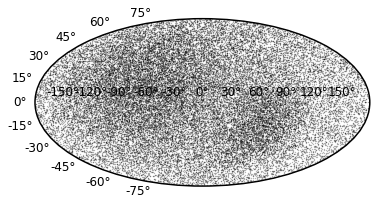

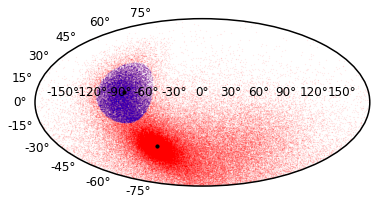

In [184]:
netpm = np.sqrt(p_galactic_l*p_galactic_l + p_galactic_b*p_galactic_b)
criteria = (lmc==0)&(distance>60.)#&(netpm>.5)&(netpm<1.0)

plt.subplot(111, projection="aitoff")
#plt.scatter(galactic_l[criteria],galactic_b[criteria],color='red',s=.1,alpha=0.1)
plt.scatter(galactic_l[criteria][::5],galactic_b[criteria][::5],color='black',s=.1,alpha=0.4)


criteria = (lmc==1)&(distance>40.)#&(netpm>.5)&(netpm<1.0)

wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)

plt.figure()
plt.subplot(111, projection="aitoff")
plt.scatter(galactic_l[criteria],galactic_b[criteria],color='red',s=.1,alpha=0.1)
plt.scatter(galactic_l[criteria][wakedist<30.*np.pi/180.],galactic_b[criteria][wakedist<30.*np.pi/180.],color='blue',s=.1,alpha=0.1)
plt.scatter([-63*np.pi/180.],[-45*np.pi/180.],color='black',s=10,alpha=1.)
plt.scatter([-85*np.pi/180.],[10*np.pi/180.],color='black',s=10,alpha=1.)





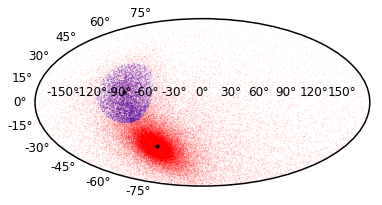

In [251]:
criteria = (lmc==1)&(distance>120.)#&(netpm>.5)&(netpm<1.0)
criteria = (lmc==1)&(distance>20.)&(distance<70.)#&(netpm>.5)&(netpm<1.0)


wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)

plt.figure()
plt.subplot(111, projection="aitoff")
plt.scatter(galactic_l[criteria],galactic_b[criteria],color='red',s=.1,alpha=0.1)
plt.scatter(galactic_l[criteria][wakedist<30.*np.pi/180.],galactic_b[criteria][wakedist<30.*np.pi/180.],color='blue',s=.1,alpha=0.1)
plt.scatter([-63*np.pi/180.],[-45*np.pi/180.],color='black',s=10,alpha=1.)
plt.scatter([-85*np.pi/180.],[10*np.pi/180.],color='black',s=10,alpha=1.)




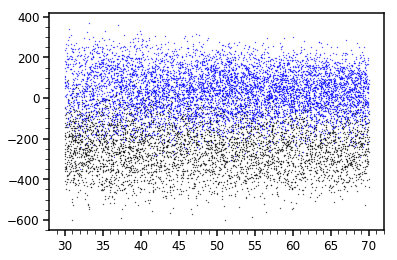

In [209]:
criteria = (lmc==0)&(distance>30.)&(distance<70.)#&(netpm>.5)&(netpm<1.0)
wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)
plt.scatter(distance[criteria][wakedist<30.*np.pi/180.],vlos[criteria][wakedist<30.*np.pi/180.],color='black',s=.1)


criteria = (lmc==1)&(distance>40.)#&(netpm>.5)&(netpm<1.0)
criteria = (lmc==1)&(distance>30.)&(distance<70.)#&(netpm>.5)&(netpm<1.0)


wakedist = haversine(galactic_l[criteria],galactic_b[criteria],-85*np.pi/180.,10.*np.pi/180.,deg=False)
plt.scatter(distance[criteria][wakedist<30.*np.pi/180.],vlos[criteria][wakedist<30.*np.pi/180.],color='blue',s=.1)



In [186]:
Amod = define_transformation_matrix(-63.*np.pi/180.,-45.*np.pi/180.,\
                                    -85.*np.pi/180.,10.*np.pi/180.,\
                                    start=-50)
print(Amod)



[[ 0.32423336 -0.60250044 -0.7292914 ]
 [-0.08476367 -0.78634254  0.61194814]
 [-0.94217188 -0.13659659 -0.30602863]]


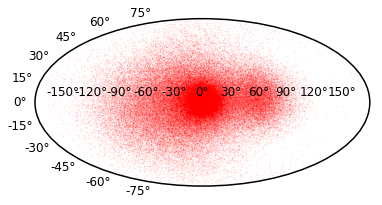

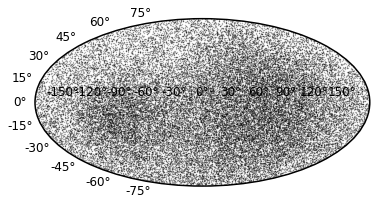

In [187]:
galactic_l_prime,galactic_b_prime = rotate_arbitrary(galactic_l,galactic_b,Amod)

criteria = (lmc==1)&(distance>40.)#&(netpm>.5)&(netpm<1.0)
plt.figure()
plt.subplot(111, projection="aitoff")
plt.scatter(galactic_l_prime[criteria],galactic_b_prime[criteria],color='red',s=.1,alpha=0.1)


criteria = (lmc==0)&(distance>40.)#&(netpm>.5)&(netpm<1.0)

plt.figure()
plt.subplot(111, projection="aitoff")
#plt.scatter(galactic_l[criteria],galactic_b[criteria],color='red',s=.1,alpha=0.1)
plt.scatter(galactic_l_prime[criteria][::5],galactic_b_prime[criteria][::5],color='black',s=.1,alpha=0.4)



In [217]:
def hist_2d(x,y,xbins,ybins,weights=None,sky=True):
    """easy 2d histogram for the surface of a sphere (aka the sky)"""
    
    
    X,Y = np.meshgrid(xbins,ybins)
    
    if weights is None:
        weights = np.ones(x.size)
        
        
    
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    img = np.zeros([xbins.size,ybins.size])
    #Nxindx = (np.floor((x - np.nanmin(xbins))/(dx))).astype('int')
    #Nyindx = (np.floor((y - np.nanmin(ybins))/(dy))).astype('int')
    Nxindx = (np.round((x - np.nanmin(xbins))/(dx))).astype('int')
    Nyindx = (np.round((y - np.nanmin(ybins))/(dy))).astype('int')


    for xval in range(0,xbins.size):
        for yval in range(0,ybins.size):
            w = np.where((Nxindx==xval) & (Nyindx==yval))[0]
            if len(w) > 0:
                img[xval,yval] += np.nansum(weights[w])#/(np.cos(yval*np.pi/180.))#*np.cos(yval*np.pi/180.))

    if sky:
        return X,Y,img.T/np.cos(Y*np.pi/180.)
    else:
        return X,Y,img.T
    #return X,Y,np.cos(Y*np.pi/180.)



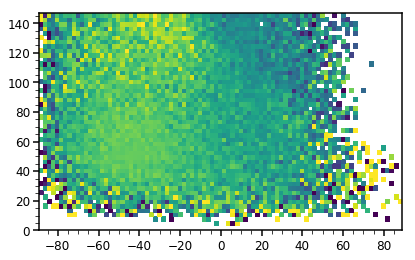

In [250]:
ddeg = 2.
bvals = np.arange(-90,90,ddeg)+ddeg/2.
dvals = np.arange(0.,150.,3.)


criteria = (lmc==1)&(galactic_l<0)


X,Y,img_ZL = hist_2d(galactic_b[criteria]*180./np.pi,distance[criteria],\
                        bvals,dvals,weights=mass[criteria],sky=False)
X,Y,img_ZV = hist_2d(galactic_b[criteria]*180./np.pi,distance[criteria],\
                        bvals,dvals,weights=mass[criteria]*galactic_l[criteria],sky=False)

fig = plt.figure(figsize=(6.5,4))
#ax1 = fig.add_axes([0.0,0.05,0.5,0.8], projection="aitoff")
#ax2 = fig.add_axes([0.5,0.05,0.5,0.8], projection="aitoff")
ax1 = fig.add_subplot(111)
#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
#ax1.pcolormesh(X*np.pi/180.,Y,np.log10(img_ZL),cmap=cm.Greys)
ax1.pcolormesh(X,Y,img_ZV/img_ZL,vmin=-(3./4)*np.pi,vmax=-np.pi/4.,cmap=cm.viridis)

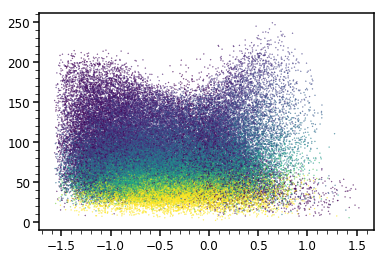

In [211]:
w = (lmc==1)&(galactic_l<0)

plt.scatter(galactic_b[w],distance[w],color=cm.viridis(p_galactic_b[w]/1.5,1.),s=.1)
#plt.axis([])


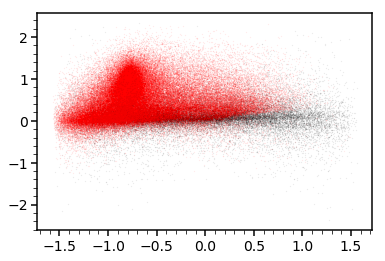

In [104]:
netpm = np.sqrt(p_galactic_l*p_galactic_l + p_galactic_b*p_galactic_b)
criteria = (lmc==0)&(distance>40.)#&(netpm>.5)&(netpm<1.0)

#plt.scatter(galactic_l[criteria],galactic_b[criteria],color='red',s=.1,alpha=0.1)
plt.scatter(galactic_b[criteria][::10],p_galactic_b[criteria][::10],color='black',s=.1,alpha=0.1)

criteria = (lmc==1)&(distance>40.)#&(netpm>.5)&(netpm<1.0)

plt.scatter(galactic_b[criteria],p_galactic_b[criteria],color='red',s=.1,alpha=0.1)




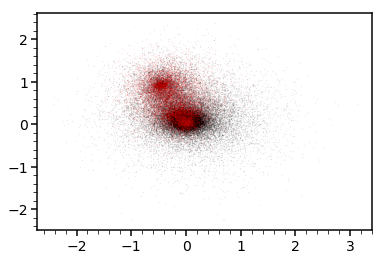

In [105]:
plt.scatter(p_galactic_l[distance>40.][::10],p_galactic_b[distance>40.][::10],color='black',s=.1,alpha=0.1)
plt.scatter(p_galactic_l[(lmc==1)&(distance>40.)][::10],p_galactic_b[(lmc==1)&(distance>40.)][::10],color='red',s=.1,alpha=0.1)





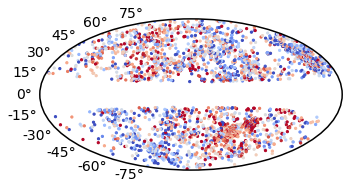

In [135]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0.05,0.1,0.9,.7], projection="aitoff")

lcoord = np.array(RRLcoords.l[bigd])
lcoord[lcoord>180] -= 360.

ax.scatter(-(np.pi/180.)*lcoord,(np.pi/180.)*np.array(RRLcoords.b[bigd]),\
           color=cm.coolwarm((np.array(RRLcoords.pm_b)[bigd]+2.)/4.,1.),s=5.)

#ax.scatter(-(np.pi/180.)*np.array(RRL.l[bigd2]),(np.pi/180.)*np.array(RRL.b[bigd2]),\
#           facecolor='none',edgecolor='red',s=3.,lw=.5)



ax.set_xticklabels(())
plt.tight_layout()
#plt.savefig('/Users/mpetersen/Downloads/rrlyrae_20_30.png',dpi=300)

In [189]:
bigd = np.where((alldist3>60) & (RRL['parallax']/RRL['parallax_error']<3) & (np.abs(np.array(RRLcoords.b))>15))[0]



# try a simple 2d histogram on the sky
lbins = np.linspace(-180.,180.,40)
bbins = np.linspace(-90.,90.,40)

img = np.zeros([lbins.size,bbins.size])
imgw = np.zeros([lbins.size,bbins.size])


lvals = np.array(RRLcoords.l[bigd])
bvals = np.array(RRLcoords.b[bigd])
wvals = np.array(RRLcoords.pm_b[bigd])

# enforce correct projection
lvals[lvals>180.] -=360.

for i in range(0,lvals.size):
    lindx = int(lbins.size*(lvals[i]+180.)/360.)
    bindx = int(lbins.size*(bvals[i]+90.)/180.)
    
    #print(lindx,bindx)
        
    if ((lindx>0)&(lindx<lbins.size-1)&(bindx>0)&(bindx<bbins.size-1)):
        img[lindx,bindx] += 1
        imgw[lindx,bindx] += wvals[i]
    
    
# set limits for images later
imgf = np.log10(img.T.reshape(-1,))
crange = np.linspace(np.nanpercentile(imgf,89.3),np.nanpercentile(imgf,96.8),48)

#manually adjust downward...
crange = np.linspace(0.,0.2,48)

dc = crange[1]-crange[0]



In [ ]:
#CVALS = (img).reshape(-1,)
AVALS = np.log10((img).T.reshape(-1,)[np.isfinite(imgf)])/1.5
AVALS = np.nanmin([np.ones(AVALS.size),AVALS],axis=0)
plt.plot(AVALS[AVALS.argsort()])



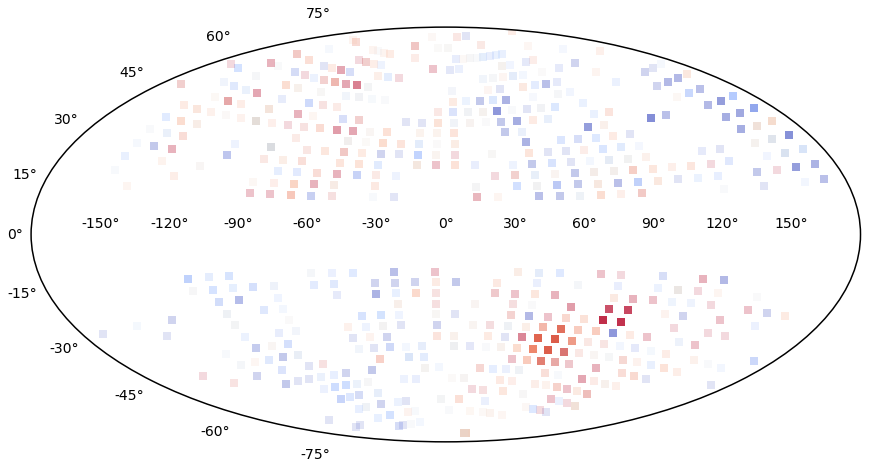

In [192]:

fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)

LL,BB = np.meshgrid(lbins,bbins)
imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]
LLf = LL.reshape(-1,)[np.isfinite(imgf)]
BBf = BB.reshape(-1,)[np.isfinite(imgf)]
CVALS = (imgw/img).T.reshape(-1,)[np.isfinite(imgf)]
AVALS = np.log10((img).T.reshape(-1,)[np.isfinite(imgf)])/2.
AVALS = np.nanmin([np.ones(AVALS.size),AVALS],axis=0)

for indx in range(0,AVALS.size):
    ax.scatter(-LLf[indx]*np.pi/180.,
           BBf[indx]*np.pi/180.,
           color=cm.coolwarm((CVALS[indx]+1.5)/3.,1.),s=80.,marker='s',alpha=AVALS[indx],lw=0.)



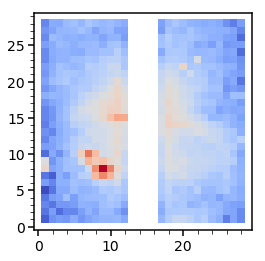

In [146]:
plt.imshow(np.log10(img),cmap=cm.coolwarm,origin='lower')

In [142]:
print(lvals)

[163.6676609  170.44418652 165.42296276 ...  33.20619341  33.55727088
  41.31816167]


In [350]:
import distributionfunction as df

In [371]:
DF = df.DF('/Users/mpetersen/Downloads/SLGridSph.mw.nodisc',verbose=1)

In [373]:
DF._compute_distribution_function()

distributionfunction.DF: constructing distribution function...
      *  DF >= 0, all good
done!


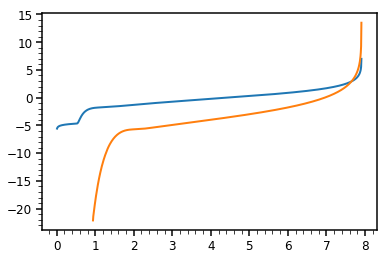

In [393]:
DF._construct_reweight(4.,rcore=0.01)

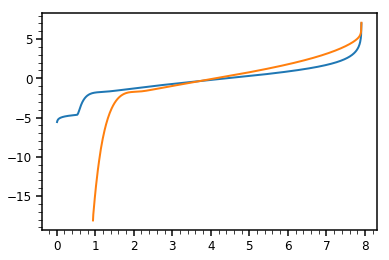

In [394]:
plt.plot(DF.E,np.log10(DF.DF))
plt.plot(DF.E,np.log10(DF.DFS))

In [395]:
DF.reweight(4.,norm=False)
print(DF.probs)

1.2494075973609424


In [764]:
# data from Zaritsky+ (2020) for stars in the MS
# see also Nidever+ (2008)?
GAIAID = [2696592708532990464,2714515130318602112,2812229896910034176,2630501957940493184,2633573237514082304,2635522259313314560,2610348528278657664,2433738824527479168,2433795548159999488,2422797172003289088,2422487281523040384,2406230521069229312,2408253858687755264,2436871844255646336,2419420915391260288]
H3ID = [111881656,117592880,117763491,118360373,119163672,119332861,119511723,119718763,119719901,119829926,119830529,120102214,120125054,120442318,120967601]
H3RA = [328.0350512,347.2415753,348.1424296,348.3172866,349.5990965,346.3077439,342.7162418,354.4038651,354.8523545,359.9671116,359.9326760,348.3230413,352.4714532,351.6534275,358.7294761]
H3DE = [4.254902,10.341434,12.910014,-8.054611,-5.356268,-4.986723,-7.813899,-11.362019,-11.153222,-10.730789,-11.184418,-17.049562,-13.831915,-10.711871,-14.353803]
RGALt =  [56,5,77,3,63,3,51,2,40,4,53,7,41,1,38,2,41,3,47,2,48,4,51,2,54,11,39,3,45,3]
RGAL = np.array(RGALt[::2])
RGALe = np.array(RGALt[1::2])
RGALNPt = [67,9,79,3,77,7,57,6,49,7,75,9,55,3,45,7,55,6,60,7,59,7,55,3,72,9,57,7,57,7]
RGALNP = np.array(RGALNPt[::2])
RGALNPe = np.array(RGALNPt[1::2])
VGSRt = [-211.6,0.5,-157.7,0.3,-163.0,0.4,-189.0,0.3,-220.7,0.6,-230.2,0.9,-179.2,0.2,-194.7,0.4,-201.2,0.4,-203.2,0.3,-184.9,0.4,-215.8,0.2,-179.3,1.0,-206.2,0.6,-180.6,0.5]
VGSR = np.array(VGSRt[::2])
VGSRe = np.array(VGSRt[1::2])




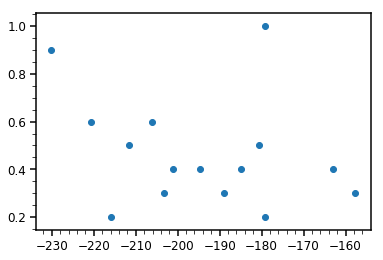

In [766]:
plt.scatter(VGSR,VGSRe)
